# 3D Quasidynamic earthquake cycle modelling. First steps: a square fault in a full space.

I've been working to get functioning 3D quasidynamic earthquake cycle simulation set up for the last month. It's been an interesting puzzle working through some of the bugs and misunderstandings that have cropped up and I just figured I'd share the story.

During this process, I've read through a lot of the literature on quasidynamic rupture modeling. I've also read a bit about fully dynamic modeling, because it has many of the same complexities when simulating through multiple earthquake cycles! But, the two main sources that I returned to again and again are:

* Lapusta and Liu, *Three-dimensional boundary integral modeling of spontaneous earthquake sequences and aseismic slip*, 2009.
* Erickson and Dunham, *An efficient numerical method for earthquake cycles in heterogeneous media: Alternating sub-basin and surface-rupturing events on faults crossing a sedimentary basin*, 2014.

The Lapusta and Liu paper goes into substantial and directly useful detail on their implementation. As a complement, the Erickson and Dunham paper is nice because it's focused on a finite difference formulation that is in the time and space domain rather than the Fourier domain setting of the Lapusta and Liu paper. My boundary element method (BEM) implementation is also a time and space domain implementation. 

For an intro to the type of problems I'm solving here, checking out [my post on doing a similar 1D "spring-block-slider" model](http://tbenthompson.com/post/block_slider/). The difference is that, here, I'm modeling a fault surface in 3D domain, rather than a point contact in a 1D domain. That adds a lot more complexity to the implementation and . Primarily, doing this in 3D requires an "elastic solver", that will take the current total slip on the fault surface, any other non-fault boundary conditions, and return the traction on the fault surface. As I mentioned in the 1D post, at a high level, the problem is a simple feedback where I loop:

```
while not done:
    slip += velocity * dt
    traction = elastic_solver(slip)
    velocity = rate_state_solver(traction)
```

However, instead of the simple forward Euler method, I'm using a Runge-Kutta (4,5) method to automatically use the largest accurate time step.

# Slip vs Slip-deficit

This is a critical distinction. When calculating the traction on the fault surface, what we care about is the relative motion of the fault with respect to its surroundings. 

# Failure to impose continuity between adjacent elements.

If there is a discontinuity in slip between two adjacent elements, a stress singularity arises at the boundary between those elements. Infinite stress then passes through the friction law, and fundamentally, results in infinite slip. That's no good. So, imposing slip continuity is essential to having reasonable behavior. And it makes fundamental physical sense too. It's unlikely that large voids are forming deep in the Earth.

This is not a problem for most other quasidynamic earthquake modeling software. If you are using the Fourier domain formulation, you get slip continuity for free by virtue of each Fourier component being continuous in space and thus the sum of those components also being continuous. On the other hand, most Okada-dislocation based approaches (e.g. [QDyn](https://github.com/ydluo/qdyn)) evaluate the stress at the centers of elements. Thus, although the model has stress singularities, the stress is never evaluated in a singular region and the problem is partially avoided. On the other hand, I'm curious how the existence of those singularities affects the final results. In general, I believe the linear (or higher order) slip interpolation that I am using on element is better for this set of problems because it allows continuity.

# Inability to trigger ruptures. 

If I initialize the model with zero slip and a initial steady state parameter, and have $a-b < 0$ everywhere, I initially expected that the model would produce ruptures. Surprisingly, that did not happen. The slip rate evolved 



In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import tectosaur.mesh.mesh_gen

from scipy.integrate import RK45
from scipy.optimize import fsolve
from qd_helpers import *

Define the material, frictional, mesh and boundary condition parameters.

The parameters in `tectosaur_cfg` determine how the integration and evaluating of the integral equations are done. I'll get into the details of Tectosaur some time in the future. For the moment, just trust that Tectosaur does actually solve linear elastic boundary value problems. It's been around the block and has been tested thoroughly, especially for the type of dislocation problems I'm solving here.

In [5]:
n_fault = 60
L = 10 * 1000 # 10 km
W = 10 * 1000 # 10 km
m = tectosaur.mesh.mesh_gen.make_rect(n_fault, n_fault, [
    [-L, 0, W], [-L, 0, -W],
    [L, 0, -W], [L, 0, W]
])
qdm = QDMeshData(m)

qd_cfg = dict(
    # Material properties
    sm = 3e10,          # Shear modulus (Pa)
    pr = 0.25,          # Poisson ratio 
    density = 2700,     # rock density (kg/m^3)

    # Frictional properties
    Dc = 0.01,         # state evolution length scale (m)
    f0 = 0.6,           # baseline coefficient of friction
    V0 = 1e-6,          # when V = V0, f = f0, V is (m/s)

    # Boundary conditions
    plate_rate = 1e-9,  # (m/s), equivalent to ~31.5 mm/yr
    
    # This is only necessary because this is a full space model and there's no concept of depth or gravity
    additional_normal_stress = 50e6, 
    
    tectosaur_cfg = dict(
        quad_mass_order = 4,       
        quad_vertadj_order = 8,
        quad_far_order = 3,
        quad_near_order = 5,
        quad_near_threshold = 2.5,
        float_type = np.float32,
        use_fmm = False,
        fmm_order = 150,
        fmm_mac = 3.0,
        pts_per_cell = 450,
        log_level = logging.INFO
    )
)
qd_cfg['cs'] = np.sqrt(qd_cfg['sm'] / qd_cfg['density'])# Shear wave speed (m/s)
qd_cfg['eta'] = qd_cfg['sm'] / (2 * qd_cfg['cs'])       # The radiation damping coefficient (kg / (m^2 * s))

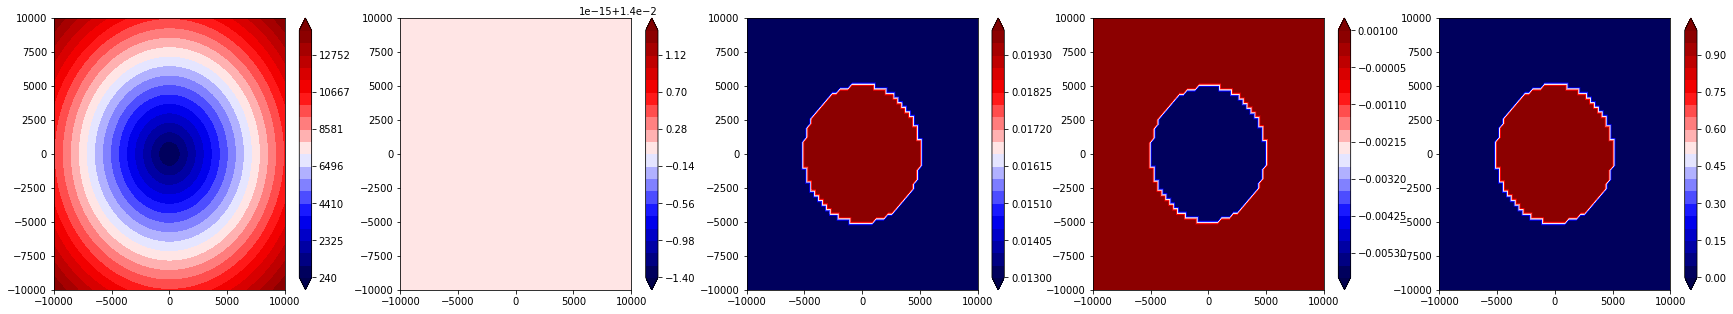

In [6]:
dof_pts = m[0][m[1]].reshape((-1,3))
distance_from_center = np.linalg.norm(dof_pts, axis = 1)

def gen_peaks(n_peaks, amplitude, width):
    n_peaks = 150
    centers = (np.random.rand(n_peaks, 2) - 0.5) * 2 * L * 0.8
    As = (np.random.rand(n_peaks) - 0.5) * 0.007
    width = 1000
    r2 = (dof_pts[:,0][:,np.newaxis] - centers[:,0]) ** 2 + (dof_pts[:,2][:,np.newaxis] - centers[:,1]) ** 2
    -r2 / (width ** 2)
    Q = np.sum(As * np.exp(-r2 / (width ** 2)), axis = 1)
    plot_fields(qdm.m, Q)
    return Q

lin_dist = L / 2
lin_slope = 0.02 / L
b = np.where(distance_from_center < lin_dist, 0.020, 0.013)#-1 * (lin_dist - distance_from_center) * lin_slope + 0.014)
a = np.ones_like(b) * 0.014
# a += gen_peaks(75, 0.003, 2000)
# b += gen_peaks(75, 0.007, 2000)
qd_cfg['a'] = a
qd_cfg['b'] = b
all_fields = np.vstack((distance_from_center, qd_cfg['a'], qd_cfg['b'], qd_cfg['a'] - qd_cfg['b'], qd_cfg['a'] - qd_cfg['b'] < 0)).T
plot_fields(qdm.m, all_fields)

Check that the "process zone" and $k_{crit}$ are good. See section 6 in Erickson et al 2014

In [7]:
mesh_L = min(L, W) / n_fault
Lb = qd_cfg['sm'] * qd_cfg['Dc'] / (qd_cfg['additional_normal_stress'] * qd_cfg['b'])
hstar = (np.pi * qd_cfg['sm'] * qd_cfg['Dc']) / (qd_cfg['additional_normal_stress'] * (qd_cfg['b'] - qd_cfg['a']))
# all_fields = np.vstack((Lb, hstar, np.ones_like(hstar) * mesh_L)).T
# plot_fields(qdm.m, all_fields)
np.min(np.abs(hstar)), np.min(Lb), mesh_L

(3141.5926535897929, 300.0, 166.66666666666666)

Setup the (slip -> traction) operator

Set up initial conditions. The edges of the fault should move at the plate rate and the interior should be moving at 1/1000th the plate rate. Then, solve for the corresponding steady state.

In [8]:
def get_traction_to_slip(qdm, qd_cfg):
    tectosaur.logger.setLevel(qd_cfg['tectosaur_cfg']['log_level'])
    cs2 = continuity_constraints(qdm.m.get_tris('fault'), np.array([]))
    cm2, c_rhs2 = build_constraint_matrix(cs2, qdm.m.n_dofs('fault'))
    hypersingular_op = make_integral_op(qdm.m, 'elasticH3', [qd_cfg['sm'], qd_cfg['pr']], qd_cfg['tectosaur_cfg'], 'fault', 'fault')
    traction_mass_op = make_mass_op(qdm.m, qd_cfg['tectosaur_cfg'])
    constrained_traction_mass_op = cm2.T.dot(traction_mass_op.mat.dot(cm2))
    def traction_to_slip(slip):
        rhs = constrained_traction_mass_op()
        rhs = hypersingular_op.dot(slip)
        #return spsolve(traction_mass_op.mat, rhs)
        out = cm2.dot(spsolve(constrained_traction_mass_op, cm2.T.dot(rhs)))
        return out
    return slip_to_traction

In [9]:
# def steady_state(V_mag):
#     # This could just be analytically solved, but why not just do it numerically...
#     def f(state):
#         return aging_law(qd_cfg, V_mag, state)
#     return fsolve(f, 0.0, maxfev = 10000)
initial_state = 0.8 * np.ones(qdm.m.tris.shape[0] * 3)

In [10]:
initial_state

array([ 0.8,  0.8,  0.8, ...,  0.8,  0.8,  0.8])

In [11]:
slip_to_traction = get_slip_to_traction(qdm, qd_cfg)
derivs = make_qd_derivs(qdm, qd_cfg, slip_to_traction)

[38120:INFO:tectosaur.util.cuda]
    Initialized CUDA on gpu: 0


In [12]:
initial_conditions = np.concatenate((np.zeros(qdm.m.n_dofs()), initial_state))
integrator = RK45(derivs, 0, initial_conditions, 1e20, atol = 1e-5, rtol = 1e-5)

0 1.22971589716e-07
V


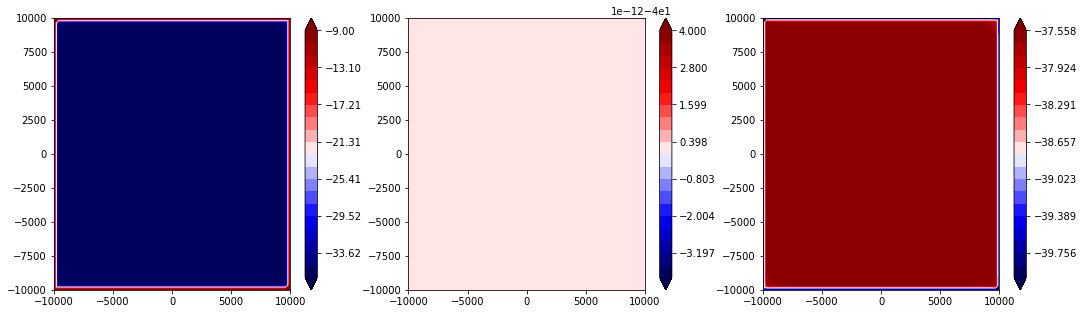

traction


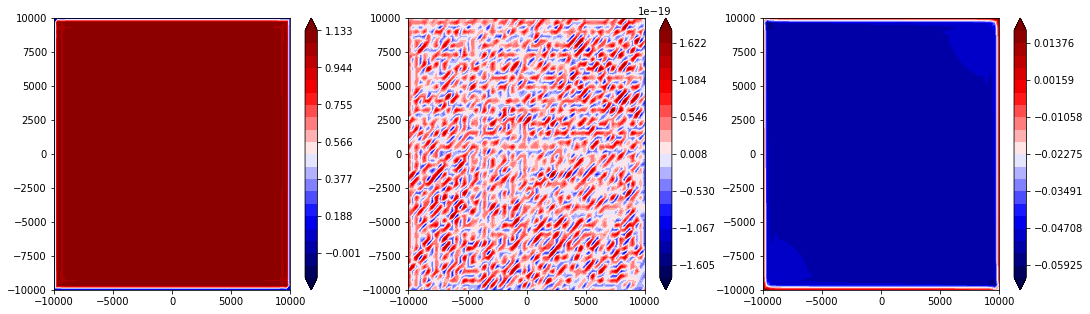

state


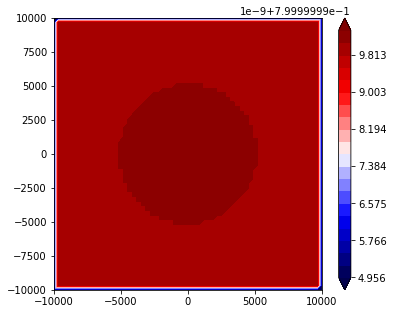

1 1.35268748687e-06
2 1.36498464584e-05
3 0.000136621436174
4 0.00136633733333
5 0.0136634963049
6 0.136635086021
7 1.36635098318


/home/tthompson/Dropbox/projects/qd/notebooks/qd_helpers.py:127: RuntimeWarning: overflow encountered in exp
  np.exp((qd_cfg['f0'] - state) / qd_cfg['b']) - (V / qd_cfg['V0'])


8 2.07809257169
9 2.44846077843
10 2.73963853649
V


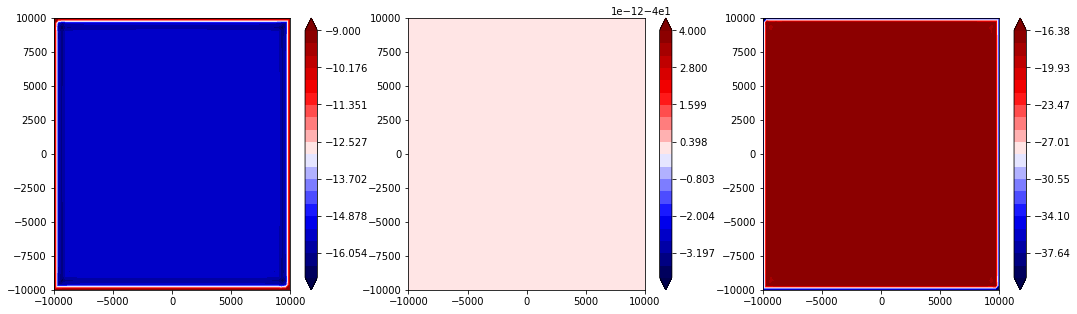

traction


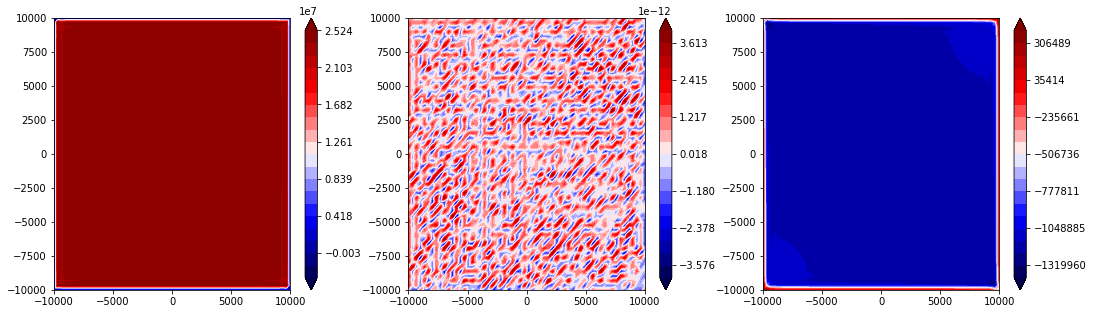

state


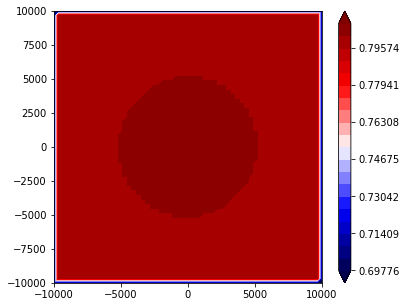

11 2.94156446455
12 3.29787689244


/home/tthompson/tools/pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:141: RuntimeWarning: overflow encountered in true_divide
  error_norm = norm(error / scale)


13 3.43974299612
14 3.59517046845
15 3.7117206917
16 3.79145558003
17 3.85409522744
18 3.90376634909
19 3.98848763125
20 4.10086932117
V


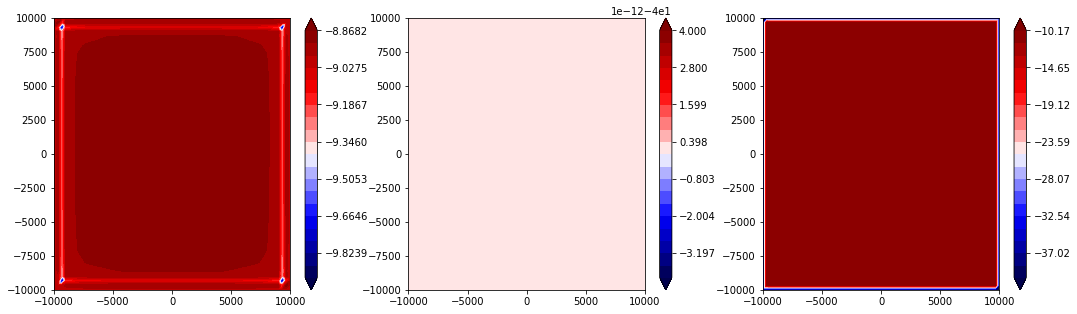

traction


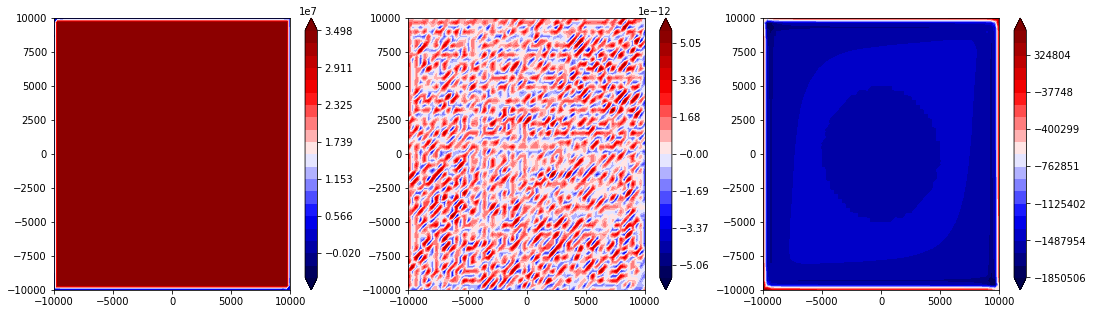

state


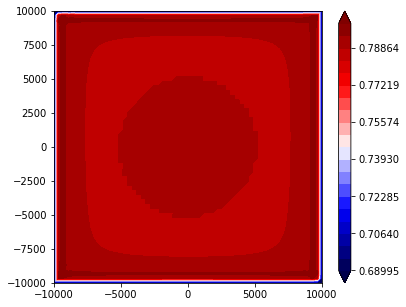

21 4.23367536456
22 4.38037549458
23 4.55460343746
24 4.75989471333
25 4.99986990153
26 5.24657496191
27 5.37537549667
28 5.62298985608
29 5.83411776014
30 6.09247523201
V


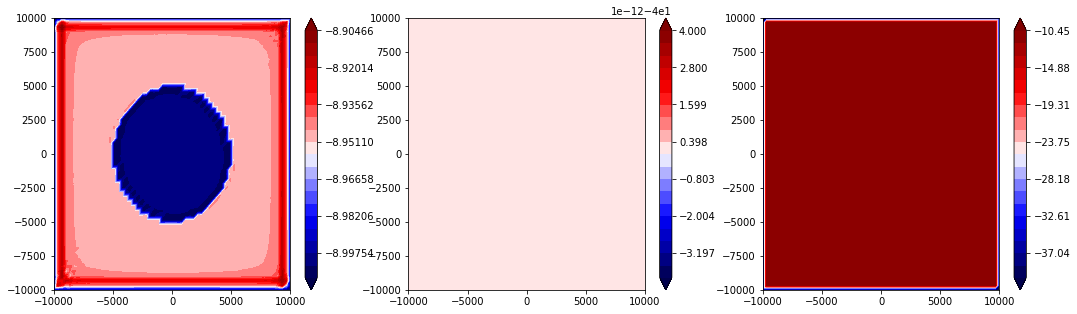

traction


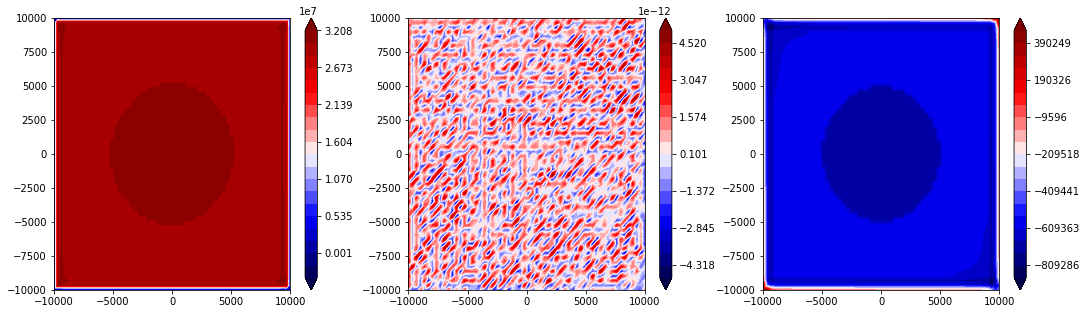

state


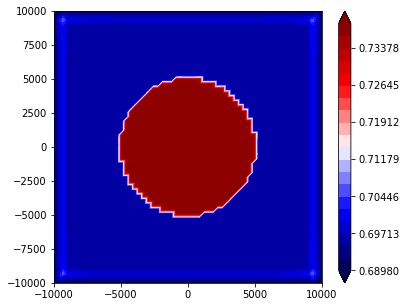

31 6.31456883696
32 6.56079778444
33 6.84683276485
34 7.19120882853
35 7.4006852035
36 7.78489234672
37 7.88012361026
38 8.28005541812
39 8.36748687581
40 8.68833975983
V


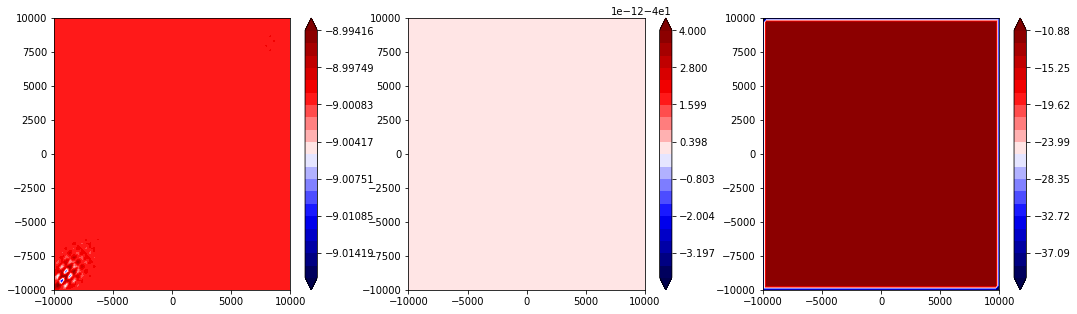

traction


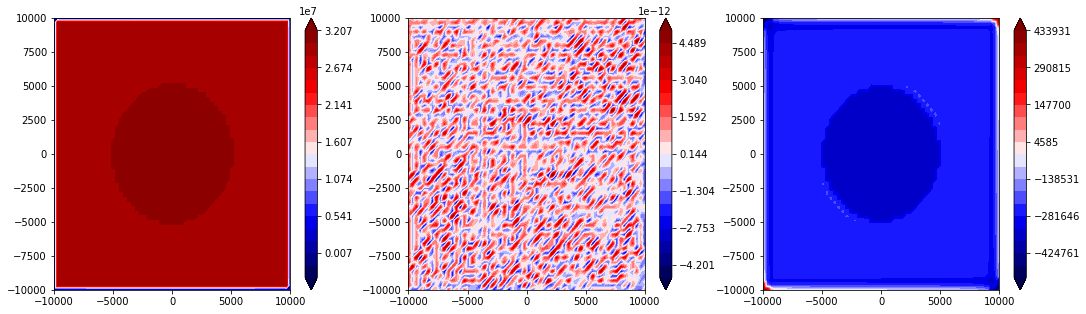

state


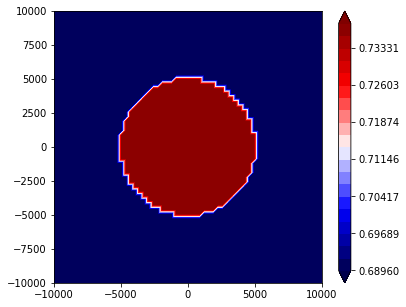

41 8.99232670786
42 9.32378943549
43 9.56316886694
44 9.91269792366
45 10.1881127695
46 10.5773299898
47 10.6603083454
48 10.9881129321
49 11.2503664183
50 11.5963347699
V


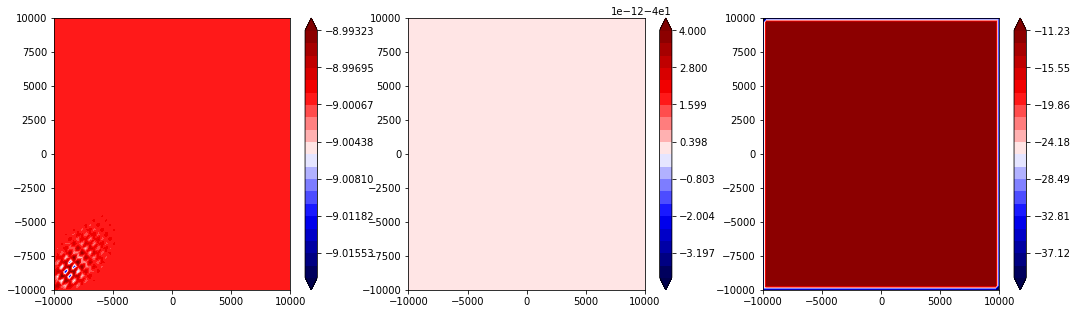

traction


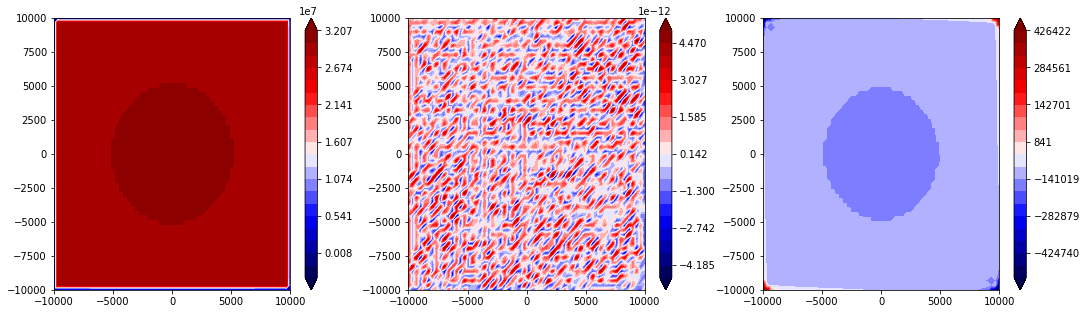

state


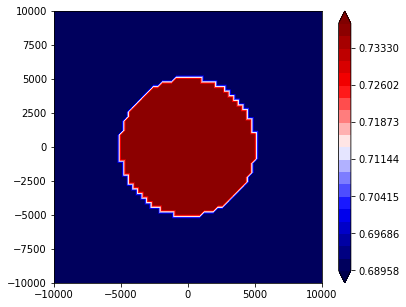

51 11.8435613823
52 12.2029042638
53 12.464181749
54 12.8394465474
55 13.0523287761
56 13.4169510844
57 13.7144217622
58 14.1047181378
59 14.1827774129
60 14.4774348553
V


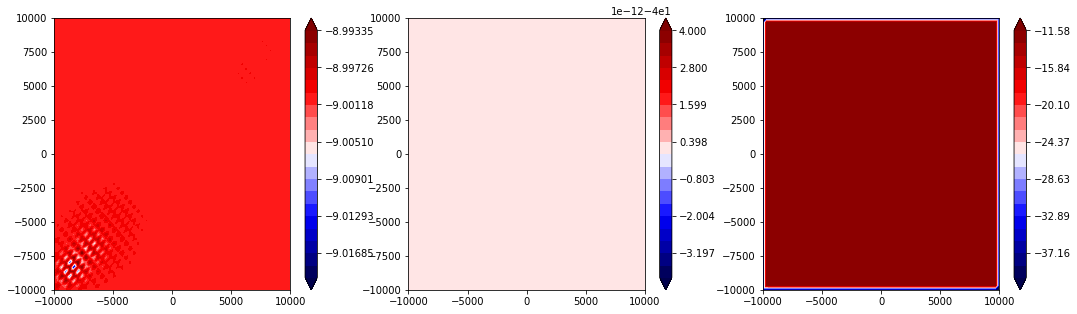

traction


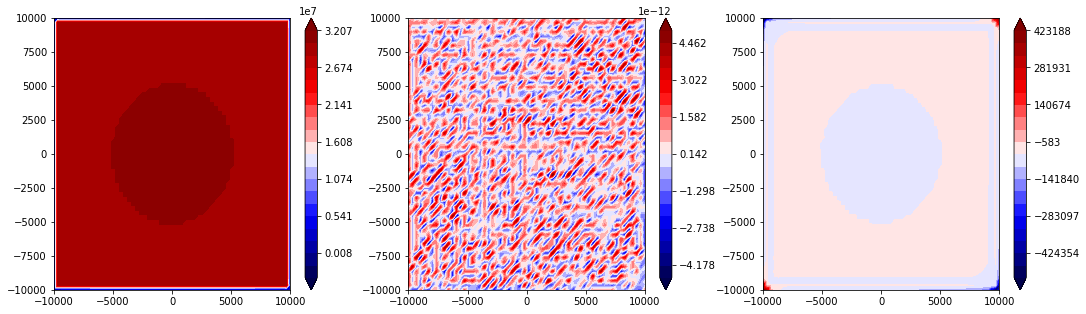

state


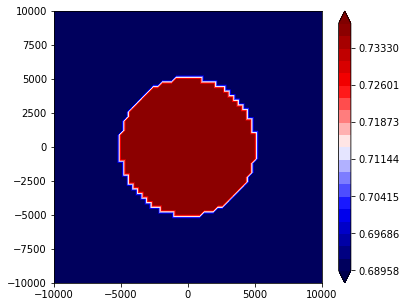

61 14.8038402632
62 14.9811335342
63 15.2974182244
64 15.6123254653
65 15.9087990274
66 16.2588291973
67 16.3288352313
68 16.5255110214
69 16.8682099956
70 17.1274883332
V


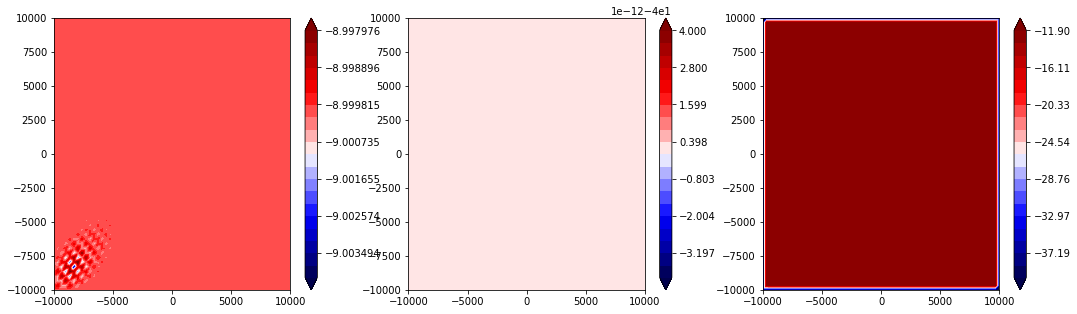

traction


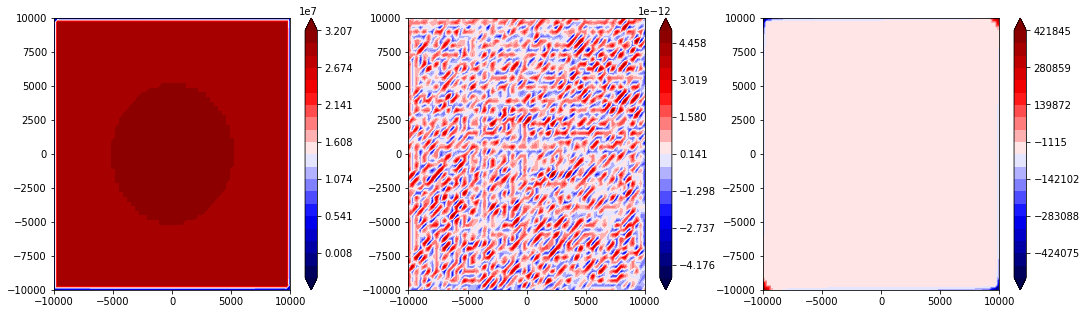

state


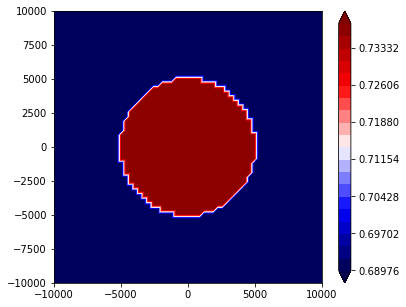

71 17.521806023
72 17.6107025198
73 17.9648820221
74 18.0988216247
75 18.4731156724
76 18.5522108455
77 18.8414427476
78 19.2100839766
79 19.2838122224
80 19.5095873067
V


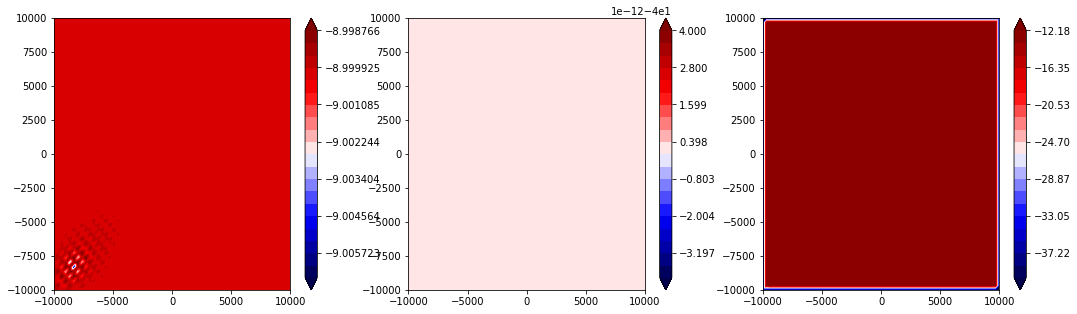

traction


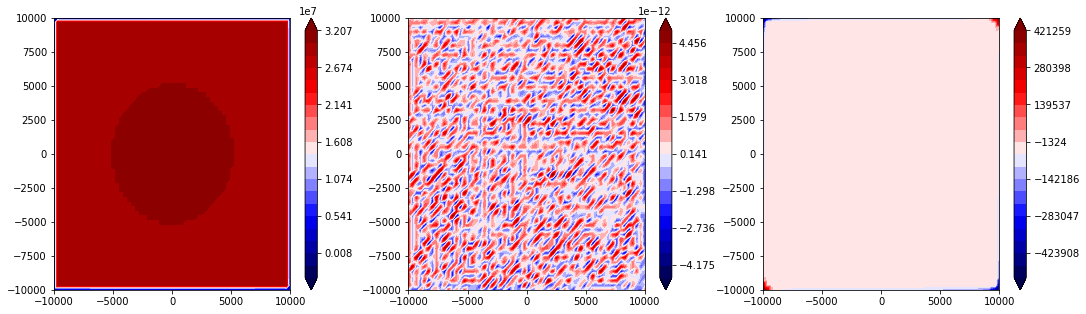

state


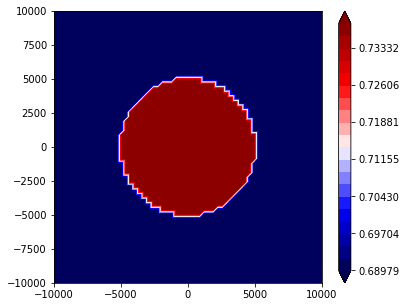

81 19.8613007563
82 20.1186675144
83 20.5182301788
84 20.6086763022
85 21.0077682363
86 21.0875866231
87 21.3024835039
88 21.633010658
89 21.9389491936
90 22.2812703806
V


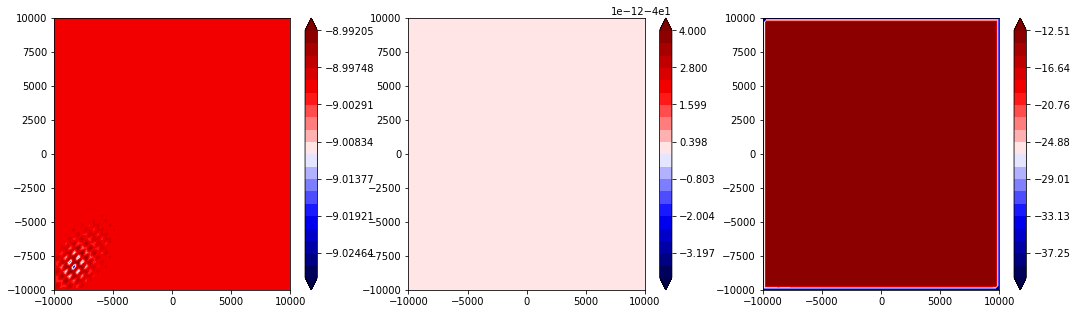

traction


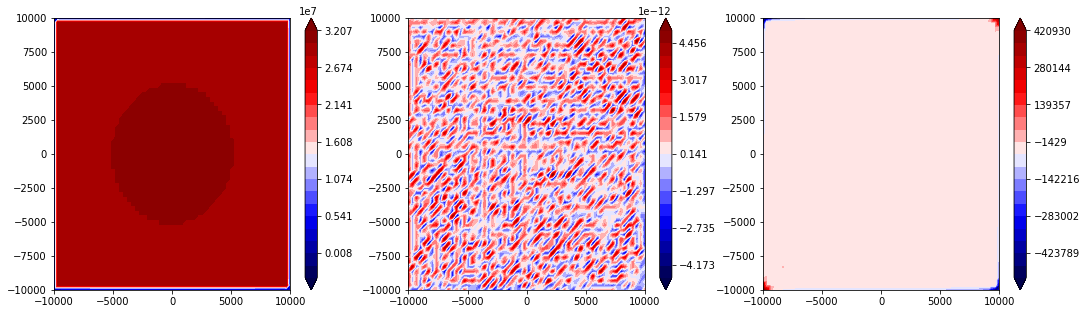

state


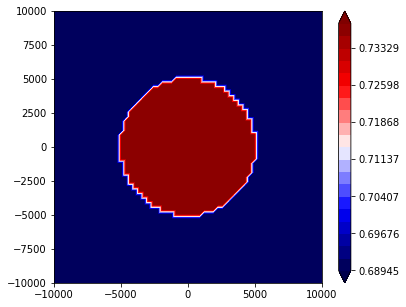

91 22.4950575316
92 22.8466202327
93 23.1303289728
94 23.5258082331
95 23.6057965517
96 23.8989241172
97 24.2438692579
98 24.3128582861
99 24.5154559052
100 24.8567044691
V


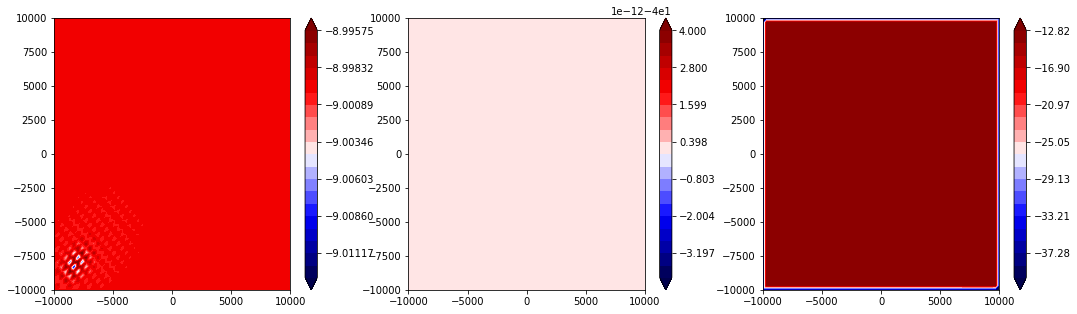

traction


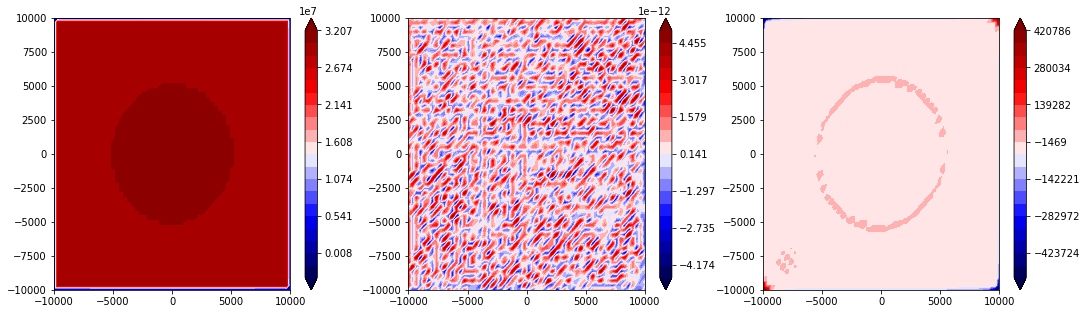

state


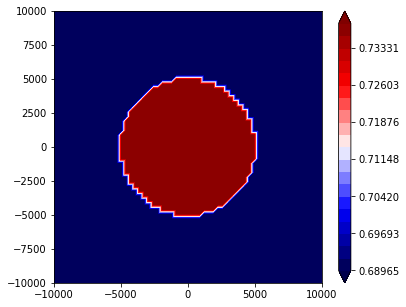

101 25.1323640207
102 25.5261160561
103 25.6085742823
104 25.9130093259
105 26.2175609906
106 26.506603142
107 26.8434931495
108 26.910871151
109 27.1004257052
110 27.4490123657
V


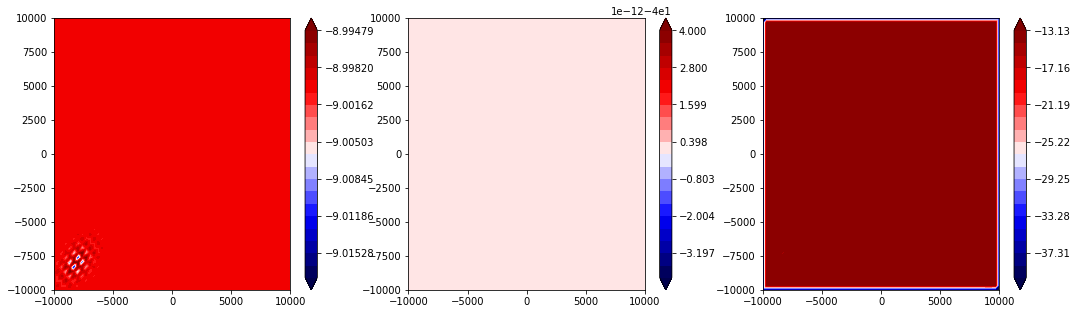

traction


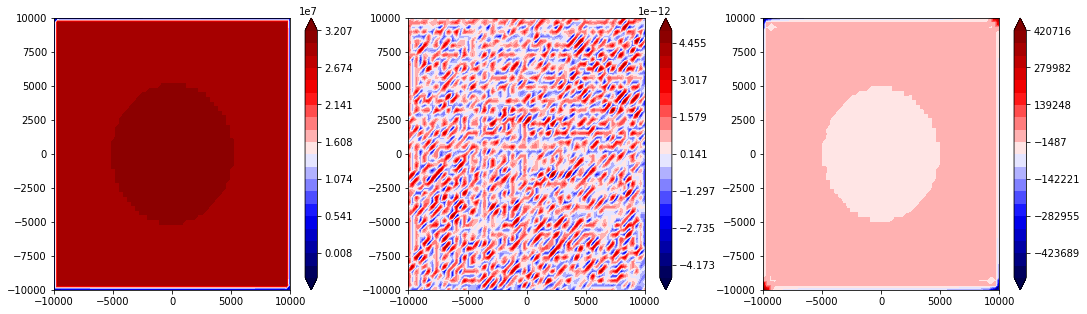

state


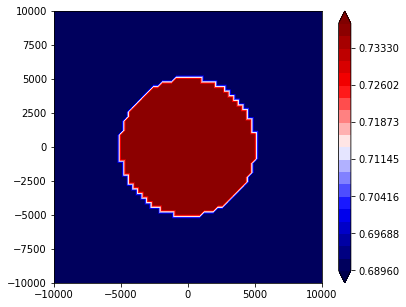

111 27.6772151489
112 28.0712962397
113 28.1682095285
114 28.6008545429
115 28.6873835458
116 28.9240531731
117 29.2569611244
118 29.5439051597
119 29.9254417643
120 30.0017490853
V


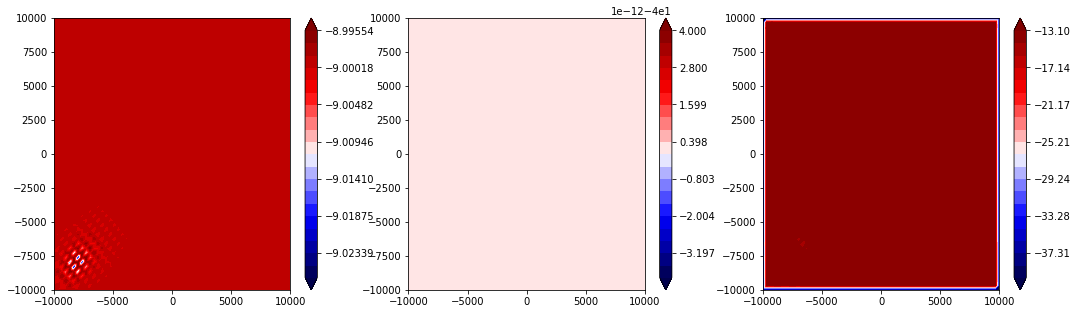

traction


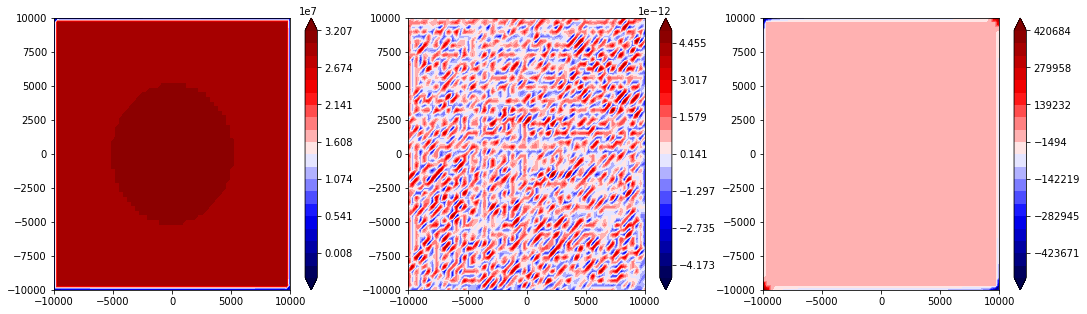

state


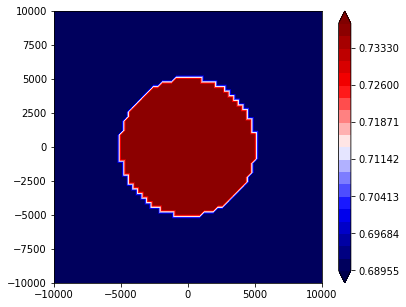

121 30.2570768261
122 30.6011045482
123 30.8365806109
124 31.2041374752
125 31.4281566815
126 31.8217087628
127 31.9191819363
128 32.3515383964
129 32.4380096884
130 32.7134903482
V


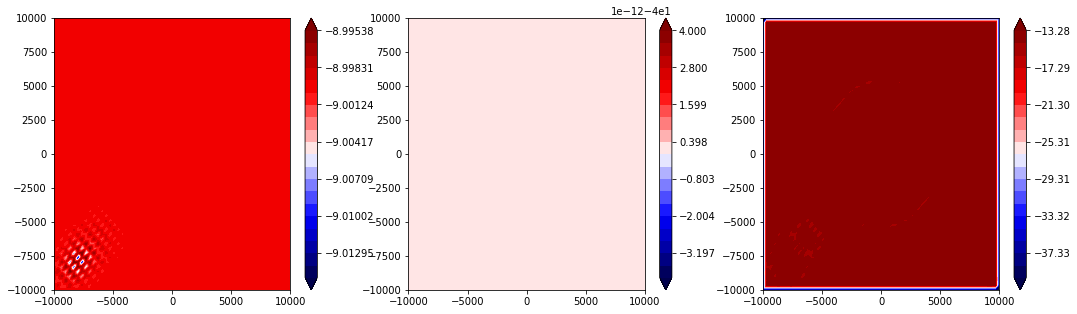

traction


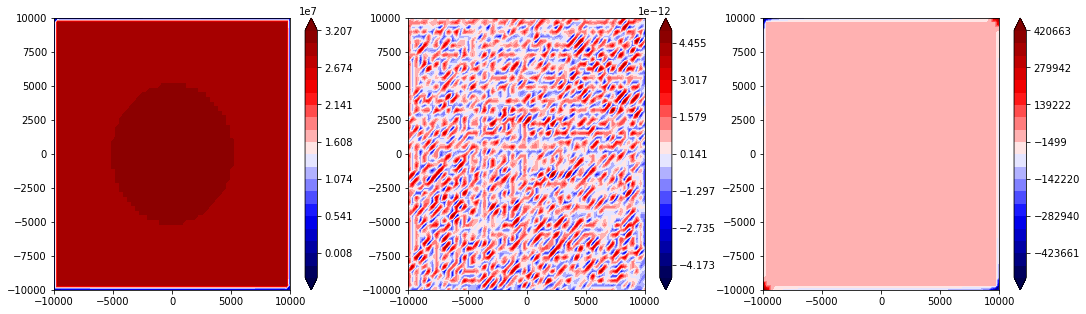

state


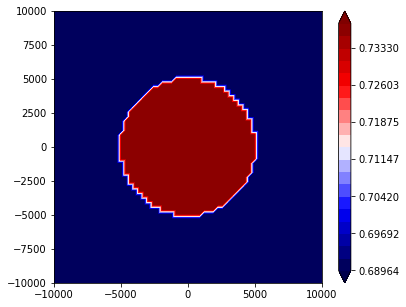

131 33.0424974047
132 33.2490955508
133 33.5821697912
134 33.8861901701
135 34.2317398788
136 34.4285628236
137 34.779655342
138 35.0555221362
139 35.4500547591
140 35.5325621677
V


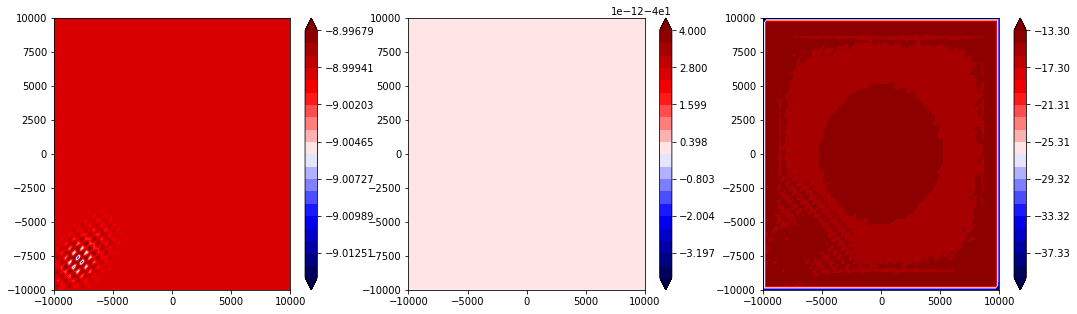

traction


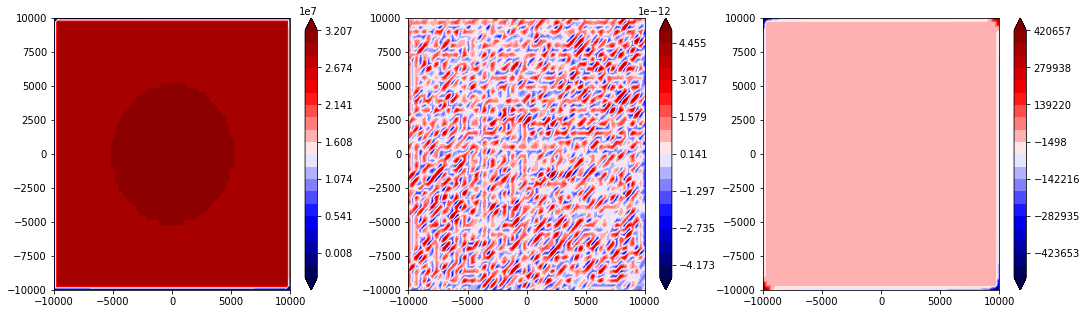

state


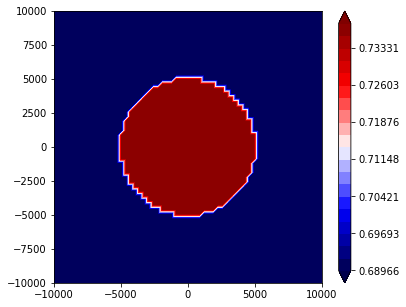

141 35.8456221256
142 36.1231961936
143 36.4627077057
144 36.6318544138
145 36.972911528
146 37.2118197907
147 37.5889966326
148 37.6801892644
149 38.1063547683
150 38.1915878691
V


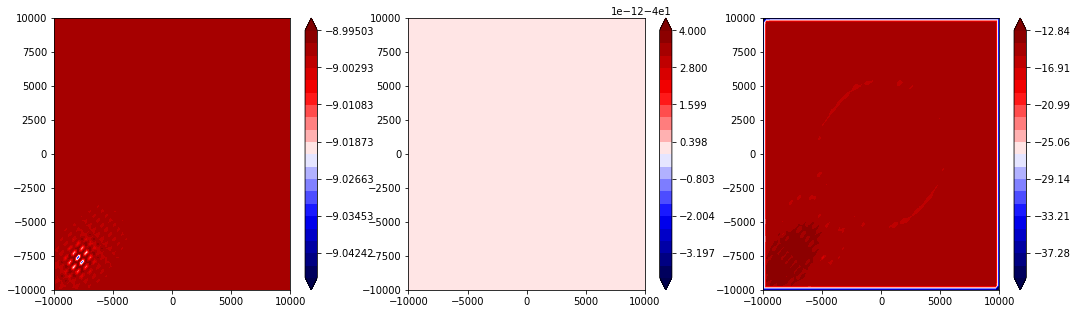

traction


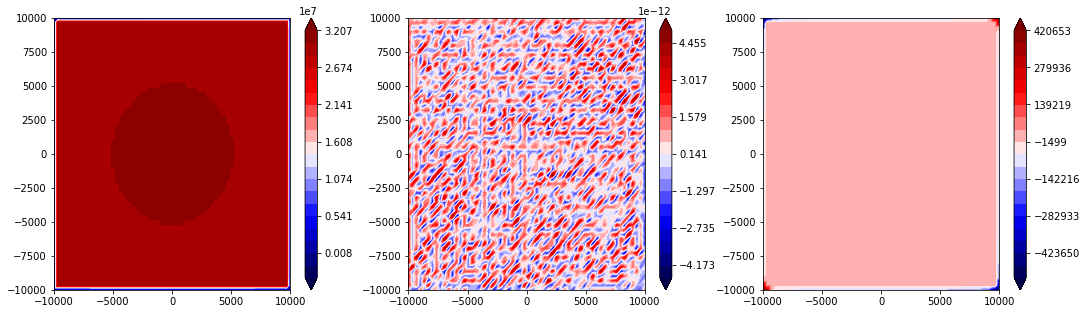

state


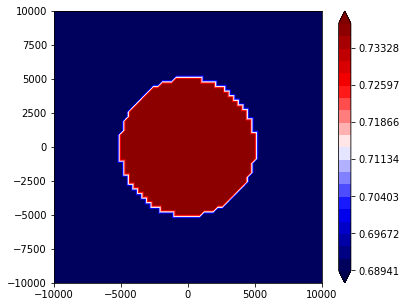

151 38.4192838063
152 38.7477397283
153 39.0494938915


In [ ]:
from tectosaur.util.timer import Timer
h_t = []
h_y = []
siay = 60 * 60 * 24 * 365.25
for i in range(10000):
    assert(integrator.step() == None)
    h_t.append(integrator.t)
    h_y.append(integrator.y.copy())
    print(i, integrator.t / siay)
    if i % 10 == 0:
        plot_setting(integrator.t, integrator.y, qdm, qd_cfg, slip_to_traction)
    if i % 200 == 0:
        np.save('results.npy', np.array([qdm.m, qd_cfg, h_t, h_y], dtype = np.object))